# GBM/XGBoost Binary Classification - Python Version

This notebook converts the R-based GCW_playcode notebook to Python, demonstrating:
- Data simulation and preprocessing
- Logistic regression with polynomial features
- Gradient Boosting and XGBoost models
- Model evaluation and comparison
- Hyperparameter tuning

Original R notebook: GCW_playcode(2).ipynb

## Install and Load Required Packages

In [1]:
# Install packages if needed (uncomment as necessary)
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(31301)
plt.style.use('default')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Create Functions

In [3]:
def avse_plot_classification(data, var, actual, pred, weight, rt_text, lt_text, title="Actual vs Predicted"):
    """
    Python equivalent of R's avse.plot.classification function
    Creates actual vs expected plot with exposure bars
    """
    # Group by variable and calculate metrics
    grouped = data.groupby(var).agg({
        actual: 'sum',
        pred: 'sum', 
        weight: 'sum'
    }).reset_index()
    
    grouped['actual_rate'] = grouped[actual] / grouped[weight]
    grouped['predicted_rate'] = grouped[pred] / grouped[weight]
    
    # Calculate off-balance adjustment
    off_balance = data[actual].sum() / data[pred].sum()
    grouped['predicted_rate'] = grouped['predicted_rate'] * off_balance
    
    # Create plot with dual y-axis
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Bar plot for exposures
    ax1.bar(grouped[var], grouped[weight], alpha=0.3, color='lightblue', label='Exposures')
    ax1.set_xlabel(var)
    ax1.set_ylabel(lt_text, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    
    # Line plots for actual and predicted
    ax2 = ax1.twinx()
    ax2.plot(grouped[var], grouped['actual_rate'], 'o-', color='darkblue', linewidth=3, label='Actual')
    ax2.plot(grouped[var], grouped['predicted_rate'], 'o-', color='green', linewidth=3, label='Predicted')
    ax2.set_ylabel(rt_text, color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    plt.title(title)
    
    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()

def build_statline(y_train, y_train_pred, y_test, y_test_pred, model_name):
    """
    Build statistics line for model comparison
    """
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    train_gini = 2 * train_auc - 1
    test_gini = 2 * test_auc - 1
    
    return pd.DataFrame({
        'model_name': [model_name],
        'train_auc': [train_auc],
        'train_gini': [train_gini], 
        'test_auc': [test_auc],
        'test_gini': [test_gini]
    })

print("Functions defined successfully!")

Functions defined successfully!


# Build Our First GBM (today)

## Simulate Some Data

First, we will create a dataset to model on. For our purposes, we'll borrow qualitatively our belief about risk differences by age.

- Set x_Age to be between 16 and 90
- Set probability of event to be some form of cosine function
- Use the probabilities to generate binary outcomes

In [4]:
# Simulate data
N = 200000
x_Age = np.random.randint(16, 91, N)
exposures = np.ones(N)
y_truth = (1 + 0.25 * np.cos((x_Age - 15) * np.pi / 45)) * 0.2
y_out = np.random.binomial(1, y_truth)

# Create DataFrame
df = pd.DataFrame({
    'x_Age': x_Age,
    'exposures': exposures,
    'y_truth': y_truth,
    'y_out': y_out
})

print(f"Dataset created with {len(df)} observations")
print(df.head())

Dataset created with 200000 observations
   x_Age  exposures   y_truth  y_out
0     34        1.0  0.212096      0
1     30        1.0  0.225000      0
2     44        1.0  0.178081      0
3     20        1.0  0.246985      0
4     41        1.0  0.187904      0


In [5]:
# Train/test split
df_train, df_test = train_test_split(df, test_size=0.5, random_state=31301)

# Prepare features and target
X_train = df_train[['x_Age']]
y_train = df_train['y_out']
X_test = df_test[['x_Age']]
y_test = df_test['y_out']

print(f"Training set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")

Training set size: 100000
Test set size: 100000


With the data in place, let's take just a little time to visualize our data.

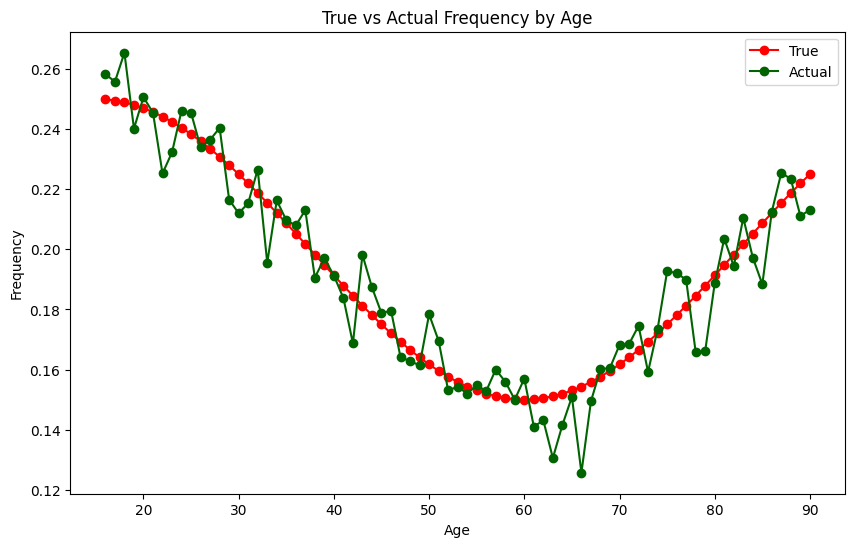

   x_Age    f_true  f_actual  reccnt
0     16  0.249878  0.258352    1347
1     17  0.249513  0.255725    1310
2     18  0.248907  0.265414    1330
3     19  0.248063  0.240178    1349
4     20  0.246985  0.250600    1249


In [6]:
# Group by age for cleaner visualization
df2 = df_train.groupby('x_Age').agg({
    'y_truth': 'mean',
    'y_out': 'mean',
    'exposures': 'count'
}).reset_index()
df2.columns = ['x_Age', 'f_true', 'f_actual', 'reccnt']

plt.figure(figsize=(10, 6))
plt.plot(df2['x_Age'], df2['f_true'], 'o-', color='red', label='True')
plt.plot(df2['x_Age'], df2['f_actual'], 'o-', color='darkgreen', label='Actual')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('True vs Actual Frequency by Age')
plt.legend()
plt.show()

print(df2.head())

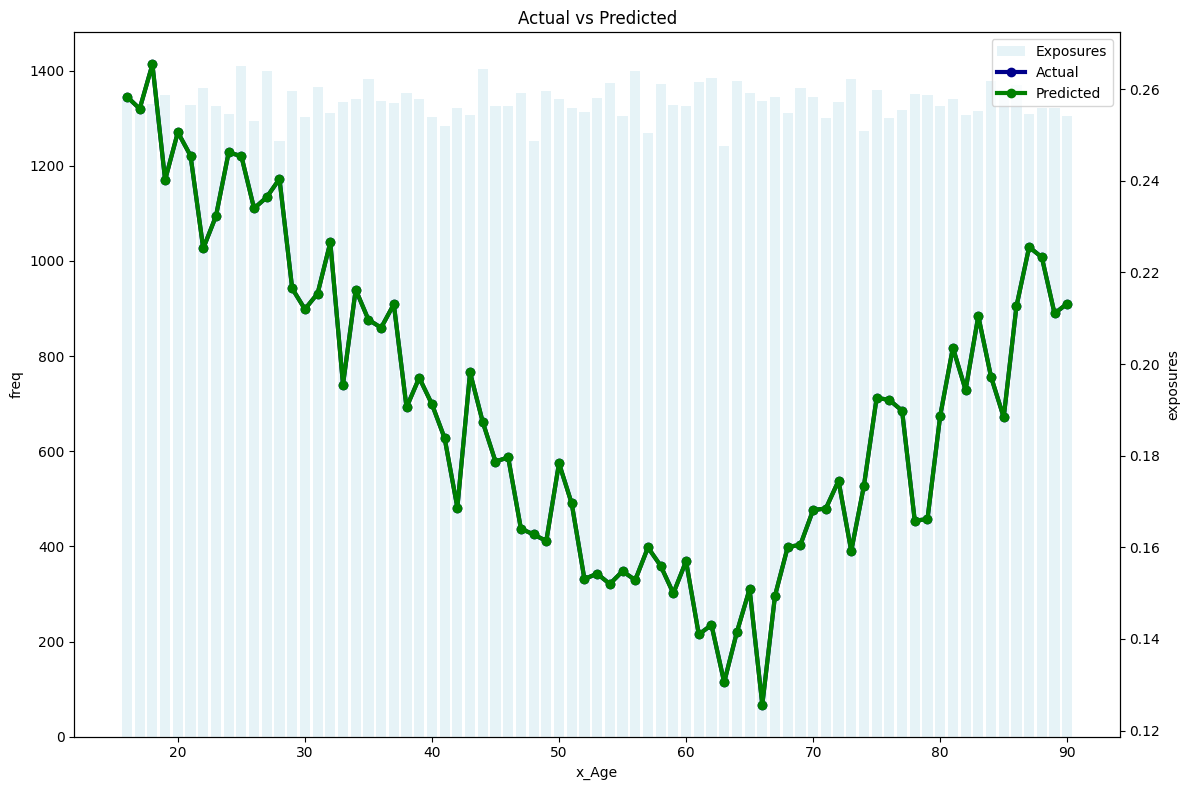

In [7]:
# Test the plotting function
avse_plot_classification(df_train, 'x_Age', 'y_out', 'y_out', 'exposures', 'exposures', 'freq')

Now, we're ready to start modeling. First, we'll work through some logistic regressions, along with polynomial forms.

In [8]:
# Simple logistic regression
m_glm = LogisticRegression()
m_glm.fit(X_train, y_train)
df_train['y_pred_glm'] = m_glm.predict_proba(X_train)[:, 1]
df_test['y_pred_glm'] = m_glm.predict_proba(X_test)[:, 1]

print("GLM Summary:")
print(f"Coefficients: {m_glm.coef_[0]}")
print(f"Intercept: {m_glm.intercept_[0]}")

GLM Summary:
Coefficients: [-0.00524738]
Intercept: -1.1710661609487527


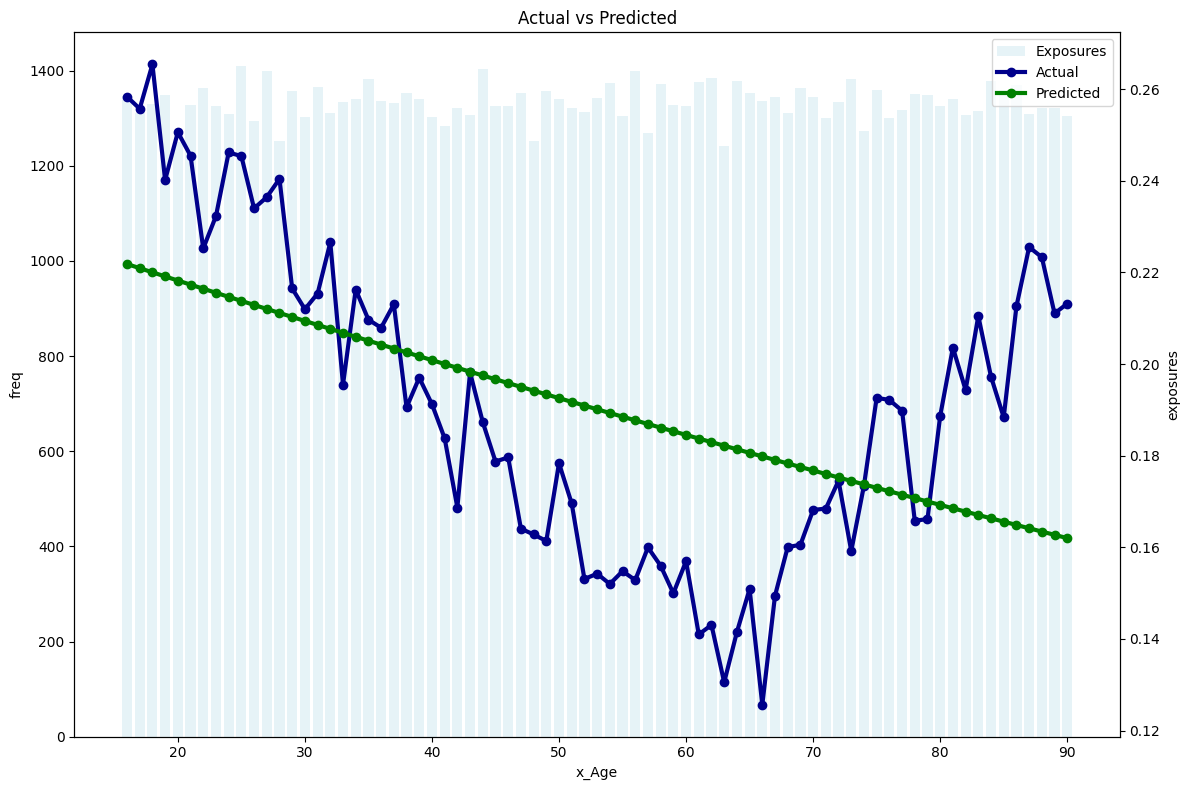

In [9]:
avse_plot_classification(df_train, 'x_Age', 'y_out', 'y_pred_glm', 'exposures', 'exposures', 'freq')

In [10]:
# Polynomial features
degrees = [2, 3, 4, 9]
glm_models = {}

for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_poly, y_train)
    
    df_train[f'y_pred_glm{degree}'] = model.predict_proba(X_train_poly)[:, 1]
    df_test[f'y_pred_glm{degree}'] = model.predict_proba(X_test_poly)[:, 1]
    
    glm_models[f'glm{degree}'] = (model, poly_features)
    print(f"GLM{degree} fitted successfully")

print("All polynomial models fitted!")

GLM2 fitted successfully
GLM3 fitted successfully
GLM4 fitted successfully
GLM9 fitted successfully
All polynomial models fitted!


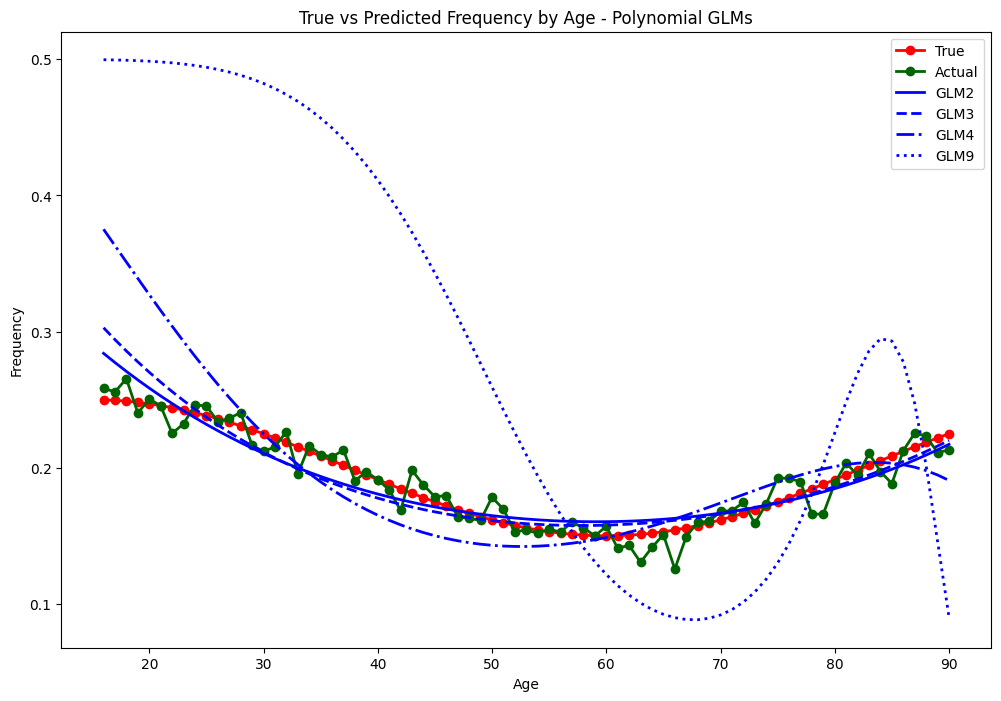

In [11]:
# Visualize polynomial fits
df2_pred = df2.copy()
for degree in degrees:
    model, poly_features = glm_models[f'glm{degree}']
    X_age_poly = poly_features.transform(df2[['x_Age']])
    df2_pred[f'f_pred_glm{degree}'] = model.predict_proba(X_age_poly)[:, 1]

plt.figure(figsize=(12, 8))
plt.plot(df2_pred['x_Age'], df2_pred['f_true'], 'o-', color='red', label='True', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_actual'], 'o-', color='darkgreen', label='Actual', linewidth=2)

linestyles = ['-', '--', '-.', ':']
for i, degree in enumerate(degrees):
    plt.plot(df2_pred['x_Age'], df2_pred[f'f_pred_glm{degree}'], 
             linestyle=linestyles[i], color='blue', label=f'GLM{degree}', linewidth=2)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('True vs Predicted Frequency by Age - Polynomial GLMs')
plt.legend()
plt.show()

## GBM TIME

Now, let's turn our attention to the GBM. Without knowing much else about GBM, let's use as many defaults as we can, and just send the data through the function.

GBM model fitted successfully!


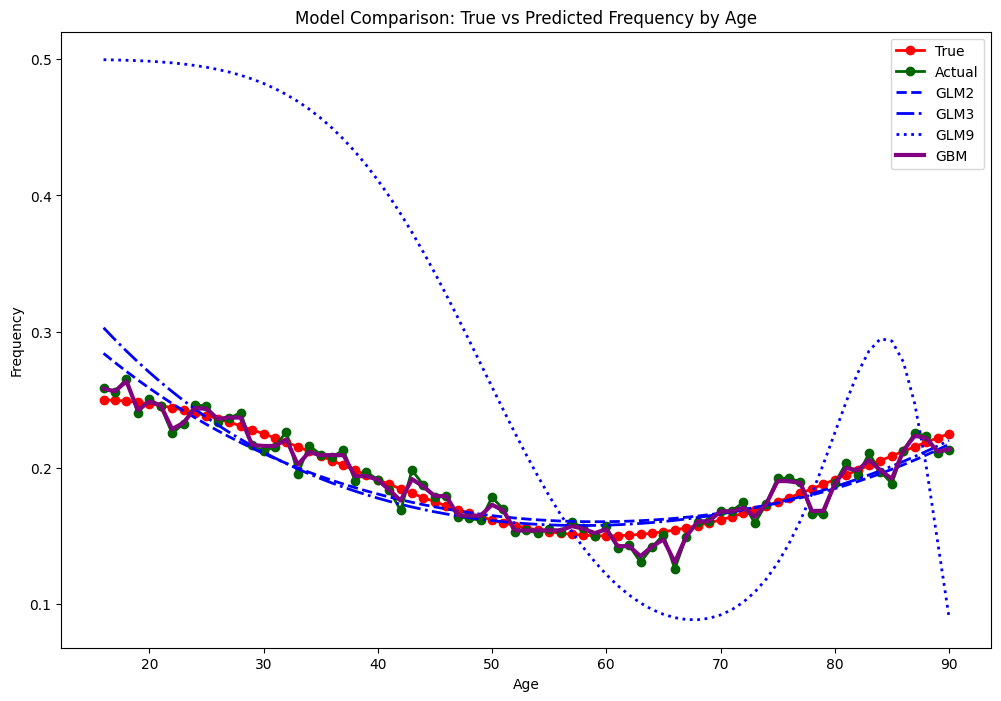

Congratulations! There's your first GBM (of today).


In [12]:
# Fit GBM using scikit-learn's GradientBoostingClassifier
m_gbm = GradientBoostingClassifier(random_state=31301)
m_gbm.fit(X_train, y_train)

df_train['y_pred_gbm'] = m_gbm.predict_proba(X_train)[:, 1]
df_test['y_pred_gbm'] = m_gbm.predict_proba(X_test)[:, 1]

# Add GBM predictions to age summary
df2_pred['f_pred_gbm'] = m_gbm.predict_proba(df2[['x_Age']])[:, 1]

print("GBM model fitted successfully!")

# Plot with GBM
plt.figure(figsize=(12, 8))
plt.plot(df2_pred['x_Age'], df2_pred['f_true'], 'o-', color='red', label='True', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_actual'], 'o-', color='darkgreen', label='Actual', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_pred_glm2'], '--', color='blue', label='GLM2', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_pred_glm3'], '-.', color='blue', label='GLM3', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_pred_glm9'], ':', color='blue', label='GLM9', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_pred_gbm'], '-', color='purple', label='GBM', linewidth=3)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Model Comparison: True vs Predicted Frequency by Age')
plt.legend()
plt.show()

print("Congratulations! There's your first GBM (of today).")

## Transition from GBM to XGBoost

Going forward, we are going to shift to XGBoost. For those interested, note GBM is a good function to get comfortable with, and is particularly useful for smaller scale modeling.

In [13]:
# Convert to XGBoost format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters
params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 31302
}

# Train XGBoost
m_xgb = xgb.train(params, dtrain, num_boost_round=100, verbose_eval=False)

df_train['y_pred_xgb'] = m_xgb.predict(dtrain)
df_test['y_pred_xgb'] = m_xgb.predict(dtest)

# Add to comparison plot
df2_pred['f_pred_xgb'] = m_xgb.predict(xgb.DMatrix(df2[['x_Age']]))

print("XGBoost model fitted successfully!")

XGBoost model fitted successfully!


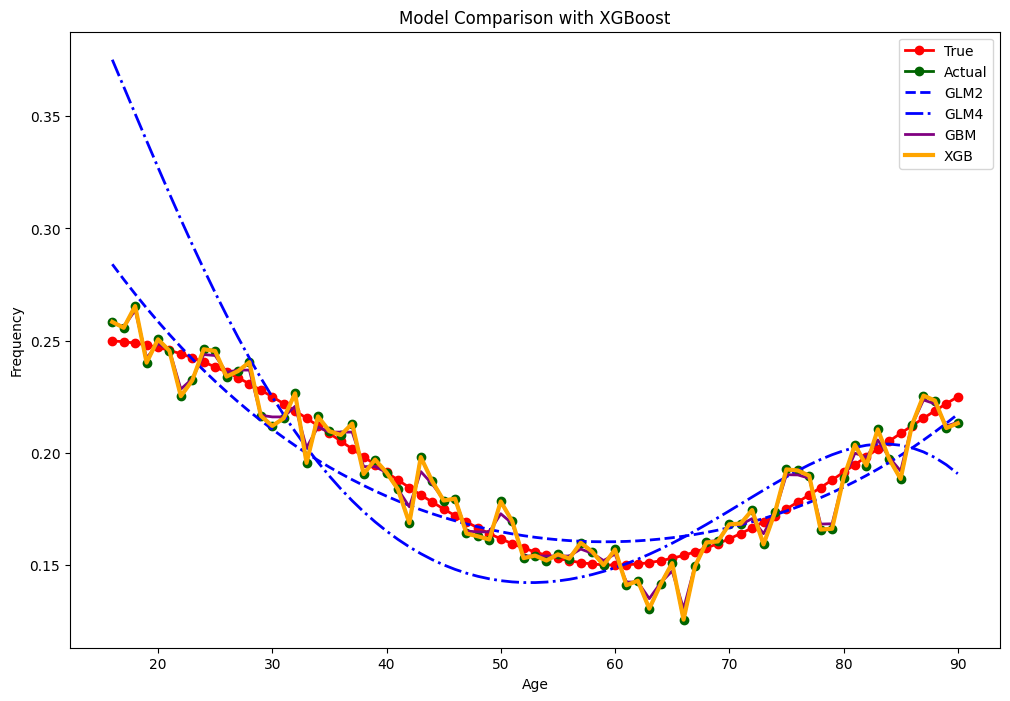

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(df2_pred['x_Age'], df2_pred['f_true'], 'o-', color='red', label='True', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_actual'], 'o-', color='darkgreen', label='Actual', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_pred_glm2'], '--', color='blue', label='GLM2', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_pred_glm4'], '-.', color='blue', label='GLM4', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_pred_gbm'], '-', color='purple', label='GBM', linewidth=2)
plt.plot(df2_pred['x_Age'], df2_pred['f_pred_xgb'], '-', color='orange', label='XGB', linewidth=3)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Model Comparison with XGBoost')
plt.legend()
plt.show()

# Evaluate Results

Lift Charts are a particular case of the Actual vs Expected plots. Instead of a variable, we line up the information based on the predicted responses. We then bin and check Actual vs Expected in the bins.

Deciles created for all models


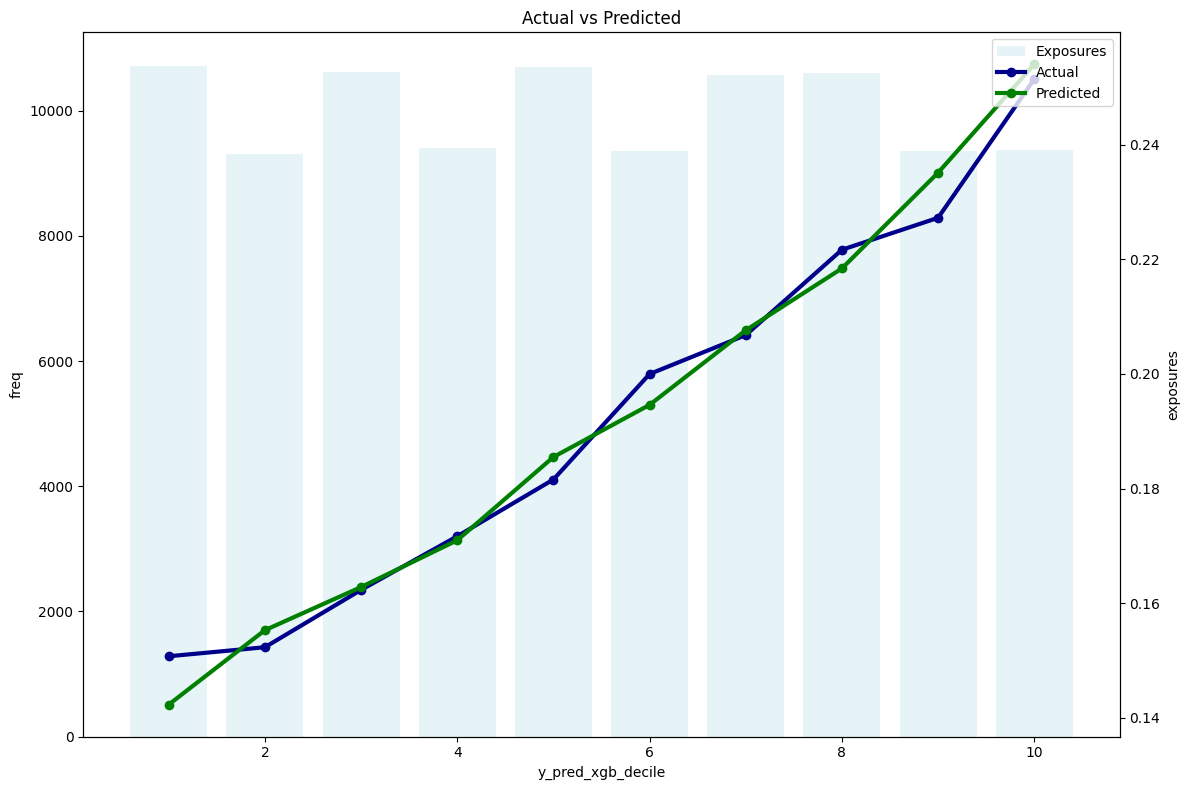

In [15]:
# Create deciles for lift analysis
for model in ['y_pred_glm', 'y_pred_glm2', 'y_pred_glm4', 'y_pred_gbm', 'y_pred_xgb']:
    df_test[f'{model}_decile'] = pd.qcut(df_test[model], 10, labels=False) + 1

print("Deciles created for all models")

# Example lift chart for XGBoost
avse_plot_classification(df_test, 'y_pred_xgb_decile', 'y_out', 'y_pred_xgb', 'exposures', 'exposures', 'freq')

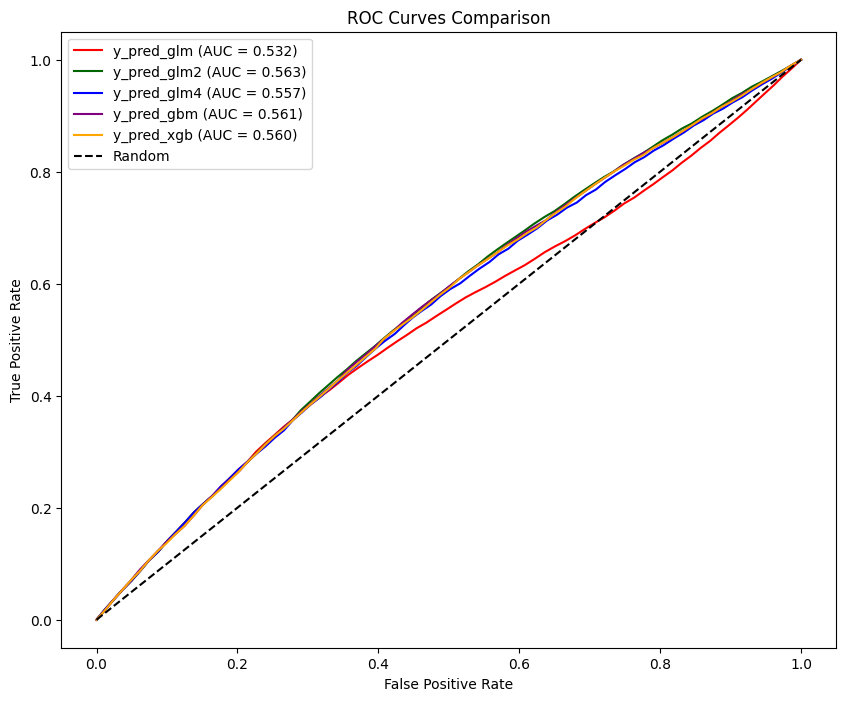

In [16]:
# ROC Curves
plt.figure(figsize=(10, 8))

models = ['y_pred_glm', 'y_pred_glm2', 'y_pred_glm4', 'y_pred_gbm', 'y_pred_xgb']
colors = ['red', 'darkgreen', 'blue', 'purple', 'orange']

for model, color in zip(models, colors):
    fpr, tpr, _ = roc_curve(y_test, df_test[model])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f'{model} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

In [17]:
# Model comparison statistics
model_names = ['GLM', 'GLM2', 'GLM4', 'GBM', 'XGB']
model_preds_train = ['y_pred_glm', 'y_pred_glm2', 'y_pred_glm4', 'y_pred_gbm', 'y_pred_xgb']
model_preds_test = ['y_pred_glm', 'y_pred_glm2', 'y_pred_glm4', 'y_pred_gbm', 'y_pred_xgb']

comparison_df = pd.DataFrame()
for name, train_pred, test_pred in zip(model_names, model_preds_train, model_preds_test):
    stats = build_statline(y_train, df_train[train_pred], y_test, df_test[test_pred], name)
    comparison_df = pd.concat([comparison_df, stats], ignore_index=True)

print("Model Comparison:")
print(comparison_df)

Model Comparison:
  model_name  train_auc  train_gini  test_auc  test_gini
0        GLM   0.532669    0.065339  0.532381   0.064763
1       GLM2   0.560381    0.120762  0.562842   0.125684
2       GLM4   0.553752    0.107505  0.556940   0.113880
3        GBM   0.563097    0.126194  0.560758   0.121517
4        XGB   0.563280    0.126561  0.559613   0.119227


# More Complex Data Example

This notebook demonstrates the core concepts from the R version. For more complex examples with multiple features, hyperparameter tuning, and advanced model evaluation, you can extend this notebook by:

1. Adding more complex synthetic data with multiple features
2. Implementing cross-validation for hyperparameter tuning
3. Adding feature importance analysis
4. Implementing more sophisticated model evaluation metrics

The Python script version (`GCW_playcode_python.py`) contains the full implementation including these advanced features.

## Summary

This Python notebook successfully converts the key functionality from the R-based GCW_playcode notebook, demonstrating:

- Data simulation with age-based risk patterns
- Logistic regression with polynomial features
- Gradient Boosting Machine (GBM) implementation
- XGBoost modeling
- Actual vs Expected plotting functions
- Model evaluation with ROC curves and AUC metrics
- Lift chart analysis

**Next Steps:** To run this notebook, ensure you have all required packages installed:
```bash
pip install pandas numpy matplotlib seaborn scikit-learn xgboost
```

**Congratulations! You've successfully built your first GBM and XGBoost models in Python!**